## Understanding Classification
##### The reference for this code is machine learning book by Aurelion Geron

In [2]:
# We will work on the MNIST digit dataset for underestanding classification tasks.
# let's first load the dataset

from sklearn.datasets import load_digits
mnist = load_digits()
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [3]:
# let's load our features and target separately
X, y = mnist['data'], mnist['target']
X.shape, y.shape

((1797, 64), (1797,))

(-0.5, 7.5, 7.5, -0.5)

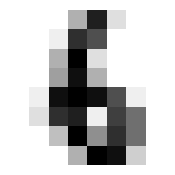

In [4]:
# this is the smaller version of the MNIST dataset, each image is of size 8*8
# we will visualise a sample image now
import matplotlib as mpl
import matplotlib.pyplot as plt
some_digit = X[34]
some_digit_image = some_digit.reshape(8, 8)

fig, ax = plt.subplots(figsize=(2, 4))

ax.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation = 'nearest')
ax.axis('off')
#ax.show()

In [5]:
# lets check the label for the above image which looks like a 6
y[34]

6

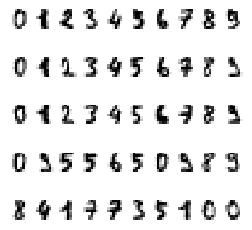

In [6]:
# yes indeed it was 6. Lets plot few image together to see the complexity of the dataset
num_rows, num_columns = 5,10
fig, axes = plt.subplots(num_rows, num_columns, figsize=(3,3))
axes = axes.flatten()
for i in range(num_rows*num_columns):
    axes[i].imshow(X[i].reshape(8, 8), cmap = mpl.cm.binary, interpolation = 'nearest')
    axes[i].axis('off')

In [7]:
# Let's now do a train test split 
X_train, X_test, y_train, y_test = X[:1400], X[1400:], y[:1400], y[1400:]

### Training a Binary Classifier

In [8]:
# we will first train the classifier to predict only the number 6
y_train_6 = (y_train == 6)
y_test_6 = (y_test == 6)

from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_6)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


SGDClassifier(random_state=42)

In [9]:
y[33]

5

In [10]:
# now check if it can predict for a test digit correctly
sgd_clf.predict([X[33]])

array([False])

### Performace metrics

In [11]:
# let's first use cross validation and check the scores
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_6, cv=3, scoring='accuracy')

array([0.99357602, 0.97858672, 0.98283262])

In [12]:
# way to high accuracy
# now lets check how much a dumb classifier which classifies every non 6 classes accurate
import numpy as np
from sklearn.base import BaseEstimator
class Never6Classifier(BaseEstimator):
    def fit(self, x, y=None):
        pass
    def predict(self, x):
        return np.zeros((len(x), 1), dtype=bool)
    
never_6_clf = Never6Classifier()
cross_val_score(never_6_clf, X_train, y_train_6, cv = 3, scoring = 'accuracy')

array([0.90149893, 0.8993576 , 0.89484979])

In [13]:
# a very high accuracy indeed! It is because 90% of the time the images are not 6. So accuracy is not a good measure we need some thing else
# there is something called confusion matrix
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_6, cv = 3)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_6, y_train_pred)

array([[1245,   13],
       [   8,  134]])

In [14]:
# TN, FP
# FN, TP
# a perfect prediction would be zero False Positive and False negatives
y_train_perfect_pred = y_train_6
confusion_matrix(y_train_6, y_train_perfect_pred)

array([[1258,    0],
       [   0,  142]])

In [15]:
# precision = TP/(TP+FP)
# recall = TP/(TP+FN)
# precision will give us information about false positives and recall will help us understand how many of the actual class is actually predicted correctly
from sklearn.metrics import precision_score, recall_score
print('Precision score',precision_score(y_train_6, y_train_pred))
print('Recall Score',recall_score(y_train_6, y_train_pred))

Precision score 0.9115646258503401
Recall Score 0.9436619718309859


In [16]:
# f1 score = 2*precision*recall/(precision+recall)
from sklearn.metrics import f1_score
print("F1 score:", f1_score(y_train_6, y_train_pred))

F1 score: 0.9273356401384083


# Day 2

In [17]:
# there is a tradeoff between precision and recall and if you set the threshold to a certain value precision and recall will change
# let's check the score
y_score = sgd_clf.decision_function([some_digit])
y_score

array([843.08029301])

In [20]:
threshold = 0
y_some_digit_pred = (y_score > threshold)
y_some_digit_pred

array([ True])

In [21]:
threshold = 1000
y_some_digit_pred = (y_score > threshold)
y_some_digit_pred

array([False])

In [22]:
# so raising the threshold reduces the recall as we can see when we set the threshold 1000 greater than the actual score it cant identify
# the digit even though it is actually a 6
# we will get scores of all instances in the training set using cross_val_score
y_scores = cross_val_predict(sgd_clf, X_train, y_train_6, cv=3, method='decision_function')

1401 1401 1400


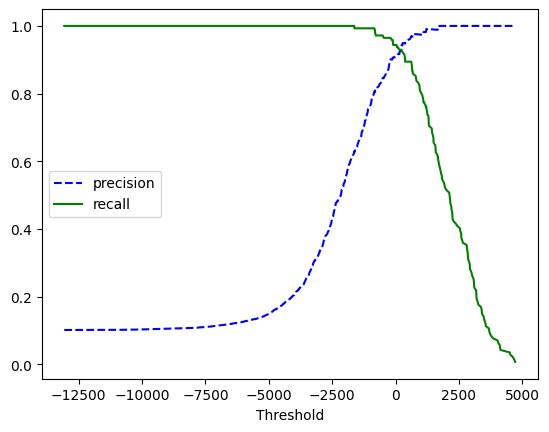

In [35]:
# now with these scores we can draw precision recall curve for all possible threshold
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_6, y_scores)
print(len(precisions),len(recalls),len(thresholds))
def plot_pre_rec_thres(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1],'b--',label='precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='recall')
    plt.xlabel('Threshold')
    plt.legend(loc='center left')

plot_pre_rec_thres(precisions,recalls,thresholds)
plt.show()

Text(0, 0.5, 'precision')

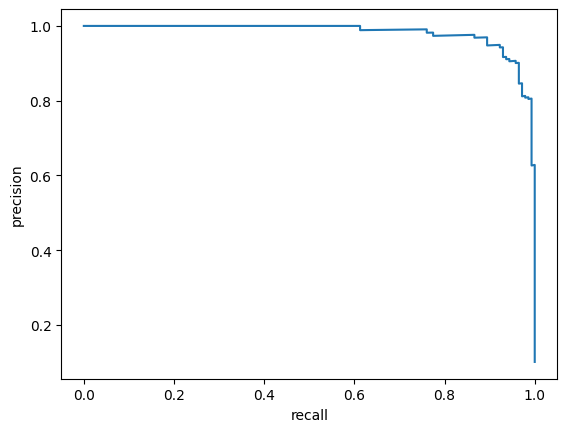

In [37]:
# let's plot precision directly against recall 
plt.plot(recalls, precisions)
plt.xlabel('recall')
plt.ylabel('precision')

In [38]:
# create a classifier with any precision you want
# create a classifier with 93% precision
threshold_93_precision = thresholds[np.argmax(precisions >= 0.93)]
threshold_93_precision

229.52765263115737

In [44]:
y_train_pred_93 = (y_scores >= threshold_93_precision)
print('Precision Score:',precision_score(y_train_6, y_train_pred_93))
print('Recall Score:',recall_score(y_train_6, y_train_pred_93))

Precision Score: 0.9361702127659575
Recall Score: 0.9295774647887324


## The ROC Curve - Reciever Operating Characteristics Curve

In [47]:
# it plots the True Positive Rate against False Positive Rate
# TPR is nothing but Recall(Sensitivity) whereas FRP is 1 - TNR(Specificity)(TN/(TN+FP))
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_6, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=None)
    plt.plot([0, 1], [0, 1],'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

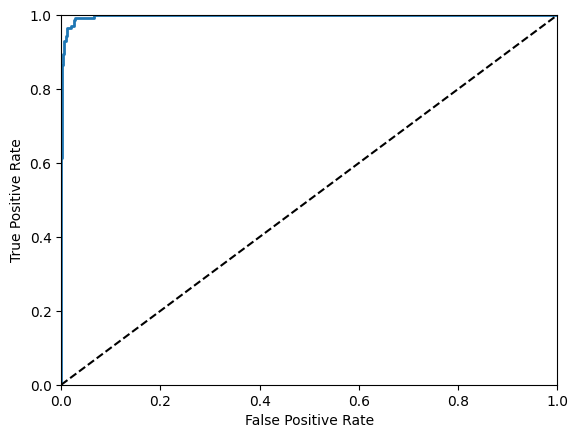

In [48]:
plot_roc_curve(fpr, tpr)
plt.show()

In [49]:
# a perfect classifier will have area equals 1; One random classifier will merge with the middle line
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_6, y_scores)

0.9978055934973913